# **Libraries**

In [1]:
!pip install seaborn matplotlib --quiet # This lines are only used in the jupyter, that's why we do not include it in the requirements.txt

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os

import pandas as pd
import numpy as np
import sqlalchemy
import pymysql
import mlflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer # for dummies
from sklearn.pipeline import Pipeline # creating a pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Review variables
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# **Reading Data**

Conection details

In [2]:
DB_HOST = "mysql" # "10.43.101.158" # "localhost" "10.43.101.158"  # Using INTERNET!
DB_USER = "root"
DB_PASSWORD = "airflow" 
DB_NAME = "project_4"
PORT= 3306

Read table from MySQL

In [3]:
connection = pymysql.connect(host=DB_HOST,
                             user=DB_USER,
                             password=DB_PASSWORD,
                             db=DB_NAME,
                             cursorclass=pymysql.cursors.DictCursor)  # Using DictCursos to obtain results as dictionaries
try:
    with connection.cursor() as cursor:
        # Query the database
        cursor.execute("SELECT * FROM project_4.raw_data;")
        result = cursor.fetchall()
    # Convert into a pd.DataFrame
    df = pd.DataFrame(result)
except Exception as e:
    # If error returns the exact error
    raise HTTPException(status_code=500, detail=str(e))
finally:
    connection.close()
# Show df
print(f"The dataframe has {len(df)} rows")
df.head()

The dataframe has 402756 rows


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,101640.0,for_sale,289900.0,4.0,2.0,0.38,1758218.0,East Windsor,Connecticut,6016.0,1617.0,1999-09-30
1,107951.0,for_sale,299900.0,3.0,2.0,0.87,1336295.0,Vernon,Connecticut,6066.0,1850.0,2015-11-09
2,80935.0,for_sale,299000.0,3.0,2.0,0.35,920059.0,North Canaan,Connecticut,6018.0,1620.0,2011-08-23
3,33714.0,for_sale,221000.0,4.0,2.0,0.32,731702.0,Windsor Locks,Connecticut,6096.0,1735.0,2014-03-03
4,29997.0,for_sale,175000.0,3.0,2.0,0.19,1382878.0,Winchester,Connecticut,6098.0,2005.0,2007-07-19


In [7]:
    return df.to_json(orient="records")

def data_processing_and_training(**context) -> None:
    """
    This step prepare the data and train the model
    """
    # Take data from previous step - data as JSON
    data = context["task_instance"].xcom_pull(task_ids="read_data") 
    df = pd.read_json(data, orient="records")

TypeError: __init__() got an unexpected keyword argument 'orient'

# **Data Understanding**

In [6]:
df.dtypes

brokered_by       float64
status             object
price             float64
bed               float64
bath              float64
acre_lot          float64
street            float64
city               object
state              object
zip_code          float64
house_size        float64
prev_sold_date     object
dtype: object

In [7]:
df["price"].unique()

array([289900., 299900., 299000., ..., 212400., 189200., 241750.])

In [8]:
df["status"].unique()

array(['for_sale'], dtype=object)

In [9]:
df["city"].unique()

array(['East Windsor', 'Vernon', 'North Canaan', ..., 'Soldotna',
       'Fairbanks', 'Ketchikan'], dtype=object)

In [10]:
df["state"].unique()

array(['Connecticut', 'Vermont', 'New Hampshire', 'New York',
       'Rhode Island', 'Maine', 'New Jersey', 'Pennsylvania', 'Delaware',
       'West Virginia', 'Ohio', 'Maryland', 'Virginia',
       'District of Columbia', 'North Carolina', 'Kentucky', 'Tennessee',
       'South Carolina', 'Georgia', 'Alabama', 'Florida', 'Mississippi',
       'Arkansas', 'Missouri', 'Louisiana', 'Indiana', 'Illinois',
       'Michigan', 'Wisconsin', 'Iowa', 'Minnesota', 'Nebraska',
       'South Dakota', 'North Dakota', 'Montana', 'Idaho', 'Kansas',
       'Oklahoma', 'Colorado', 'Wyoming', 'Texas', 'New Mexico', 'Utah',
       'Washington', 'Oregon', 'Arizona', 'California', 'Nevada',
       'Hawaii', 'Alaska'], dtype=object)

Reviewing if the is any null value

In [11]:
# Putting "" as null 
df.replace("", np.nan, inplace=True)
df.replace("?", np.nan, inplace=True)

In [12]:
pd.DataFrame(df.isna().sum()) / len(df)

,0
brokered_by,0.0
status,0.0
price,0.0
bed,0.0
bath,0.0
acre_lot,0.0
street,0.0
city,0.0
state,0.0
zip_code,0.0


Reviewing duplicated values

In [13]:
df.duplicated().sum()

0

# **Data Procesing**

## _Removing not needed files_

Converting 10 first columns and the result variable into numeric

In [4]:
unique_columns_to_use = ["price", "bed", "bath", "acre_lot", "street", "city", "state", "house_size"]
df = df[unique_columns_to_use]

In [189]:
df.dtypes

price         float64
bed           float64
bath          float64
acre_lot      float64
street        float64
city           object
state          object
house_size    float64
dtype: object

## _Delete Nulls_

In [5]:
# Putting "" as null 
df.replace("", np.nan, inplace=True)
df.replace("?", np.nan, inplace=True)
df = df.dropna()

## _Split data into train and test_

In [6]:
# Division between y and the rest of variables

y = df["price"]
X = df.drop(columns="price")

# Split train and test (80% train, 20% test)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.50, random_state=42)

## __Save Data to Clean Data__

In [7]:
DB_HOST = "mysql" # "10.43.101.158" # "localhost" "10.43.101.158"  # Using INTERNET!
DB_USER = "root"
DB_PASSWORD = "airflow" 
DB_NAME = "project_4"
PORT= 3306

In [8]:
# Creating final DataFrame to Upload
df_train_final = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
df_val_final = pd.concat([X_val, pd.DataFrame(y_val)], axis=1)
df_test_final = pd.concat([X_test, pd.DataFrame(y_test)], axis=1)

# Connect to MySQL
engine = sqlalchemy.create_engine(f'mysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{PORT}/{DB_NAME}')

# Save data, if exits append into the current table (TRAIN)
df_train_final.to_sql('clean_data_train', con=engine, if_exists='replace', index=False)
df_val_final.to_sql('clean_data_val', con=engine, if_exists='replace', index=False)
df_test_final.to_sql('clean_data_test', con=engine, if_exists='replace', index=False)
print("Saved into MySQL!")

Saved into MySQL!


# **Read Data from Clean Data**

Reading data from **train**

In [3]:
DB_HOST = "mysql" # "10.43.101.158" # "localhost" "10.43.101.158"  # Using INTERNET!
DB_USER = "root"
DB_PASSWORD = "airflow" 
DB_NAME = "project_4"
PORT= 3306

In [4]:
connection = pymysql.connect(host=DB_HOST,
                             user=DB_USER,
                             password=DB_PASSWORD,
                             db=DB_NAME,
                             port=PORT,
                             cursorclass=pymysql.cursors.DictCursor)  # Using DictCursos to obtain results as dictionaries
try:
    with connection.cursor() as cursor:
        # Query the database
        cursor.execute("SELECT * FROM project_4.clean_data_train;")
        result = cursor.fetchall()
    # Convert into a pd.DataFrame
    df_train_clean = pd.DataFrame(result)
except Exception as e:
    # If error returns the exact error
    raise HTTPException(status_code=500, detail=str(e))
finally:
    connection.close()
# Show df
print(f"The dataframe has {len(df_train_clean)} rows")
df_train_clean.head()

The dataframe has 800000 rows


,bed,bath,acre_lot,street,city,state,house_size,price
0,3,2,0.11,454281,Fort Worth,Texas,2187,464900.0
1,2,1,0.13,1777614,Great Falls,Montana,990,94500.0
2,1,1,0.01,655180,Tacoma,Washington,564,249999.0
3,3,2,0.14,882362,Little Elm,Texas,1544,359501.0
4,6,8,0.92,276682,Scottsdale,Arizona,6222,2800000.0


Reading data from **validation**

In [4]:
connection = pymysql.connect(host=DB_HOST,
                             user=DB_USER,
                             password=DB_PASSWORD,
                             db=DB_NAME,
                             port=PORT,
                             cursorclass=pymysql.cursors.DictCursor)  # Using DictCursos to obtain results as dictionaries
try:
    with connection.cursor() as cursor:
        # Query the database
        cursor.execute("SELECT * FROM project_4.clean_data_val;")
        result = cursor.fetchall()
    # Convert into a pd.DataFrame
    df_validation_clean = pd.DataFrame(result)
except Exception as e:
    # If error returns the exact error
    raise HTTPException(status_code=500, detail=str(e))
finally:
    connection.close()
# Show df
print(f"The dataframe has {len(df_validation_clean)} rows")
df_validation_clean.head()

The dataframe has 40276 rows


,bed,bath,acre_lot,street,city,state,house_size,price
0,3.0,1.0,0.16,88224.0,Tulsa,Oklahoma,1206.0,50000.0
1,2.0,2.0,0.12,575822.0,Saint Paul,Minnesota,1008.0,169900.0
2,4.0,1.0,0.20,1581880.0,Saint Louis,Missouri,1156.0,139900.0
3,1.0,1.0,2.49,520408.0,Reseda,California,532.0,265000.0
4,2.0,2.0,0.56,871582.0,Cherokee Village,Arkansas,868.0,75000.0


Reading data from **test**

In [5]:
connection = pymysql.connect(host=DB_HOST,
                             user=DB_USER,
                             password=DB_PASSWORD,
                             db=DB_NAME,
                             port=PORT,
                             cursorclass=pymysql.cursors.DictCursor)  # Using DictCursos to obtain results as dictionaries
try:
    with connection.cursor() as cursor:
        # Query the database
        cursor.execute("SELECT * FROM project_4.clean_data_test;")
        result = cursor.fetchall()
    # Convert into a pd.DataFrame
    df_test_clean = pd.DataFrame(result)
except Exception as e:
    # If error returns the exact error
    raise HTTPException(status_code=500, detail=str(e))
finally:
    connection.close()
# Show df
print(f"The dataframe has {len(df_test_clean)} rows")
df_test_clean.head()

The dataframe has 100000 rows


,bed,bath,acre_lot,street,city,state,house_size,price
0,2,1,0.17,294855,Bessemer,Alabama,816,59500.0
1,4,3,5.00,671705,New Castle,Virginia,4128,369900.0
2,2,2,0.09,671765,Phoenix,Arizona,1214,349900.0
3,3,2,4.96,212306,Barren Springs,Virginia,1836,149900.0
4,3,2,0.19,838480,Maitland,Florida,1473,489000.0


# **Delete Tables**

Verify which table are you going to delete

In [7]:
# Parameters
#DB_HOST = "mysql" # "10.43.101.158" # "localhost" "10.43.101.158"  # Using INTERNET!
#DB_USER = "root"
#DB_PASSWORD = "airflow" 
#DB_NAME = "project_4"
#PORT= 3306

# Connect to MySQL
#engine = sqlalchemy.create_engine(f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{PORT}/{DB_NAME}')

#inspector = sqlalchemy.inspect(engine)
#inspector.get_table_names()

In [8]:
############################
## Delete tables
############################


# Parameters
#DB_HOST = "mysql" # "10.43.101.158" # "localhost" "10.43.101.158"  # Using INTERNET!
#DB_USER = "root"
#DB_PASSWORD = "airflow" 
#DB_NAME = "project_4"
#PORT= 3306

# Connect to MySQL
#engine = sqlalchemy.create_engine(f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{PORT}/{DB_NAME}')

# Table name
#table_name = 'raw_data' # 'metrics_retraining_to_be_saved'

# Create MetaData
#metadata = sqlalchemy.MetaData()
#table = sqlalchemy.Table(table_name, metadata, autoload_with=engine)

# Delete table
#table.drop(engine)

#print(f"La tabla '{table_name}' ha sido borrada.")

# **Reviewing if needed a new training**

The way in which we are going to determine if it is needed to re-train a model corresponds to the following:

1. MSE in test increase more than 15%
2. MAE in test increase more than 15%
3. Training Data has increased more than 50%
4. Mean value for more or equals than 2 numerical variables is different +/- 10%
5. There are more than 5% of distinct categorical variables

In [14]:
def predict_mse_mae_actual_dataset(df_test: pd.DataFrame):
    # YOU MUST TAKE THE API NOT THE WEBAPP IN MY CASE IT WAS "http://0.0.0.0:8083" BUT API "9000"
    # WE ARE ALSO TAKING THE NETWORK VALUE NEVERTHELESS YOU CAN USE THE CONTEINER NAME (IN OUR CASE S3)

    y_test = df_test["price"]
    X_test = df_test.drop("price")
    
    os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://s3:8084" # YOU MUST TAKE THE API NOT THE WEBAPP IN MY CASE IT WAS "http://0.0.0.0:8083" BUT API "9000"
    os.environ['AWS_ACCESS_KEY_ID'] = 'admin'
    os.environ['AWS_SECRET_ACCESS_KEY'] = 'supersecret'

    # connect to mlflow
    mlflow.set_tracking_uri("http://mlflow:8087") # "http://0.0.0.0:8087")

    model_name = "model_final_project"

    # logged_model = 'runs:/71428bebed2b4feb9635714ea3cdb562/model'
    model_production_uri = "models:/{model_name}/production".format(model_name=model_name)

    print(model_production_uri)

    # Load model as a PyFuncModel.
    loaded_model = mlflow.pyfunc.load_model(model_uri=model_production_uri)
    y_pred = loaded_model.predict(X_test)

    review_test_mse = mean_squared_error(y_test, y_pred)
    review_test_mae = mean_absolute_error(y_test, y_pred)

    print(f"Best model has an mse of {review_test_mse} and mae of {review_test_mae} in test")
    return review_test_mse, review_test_mae
 

**Creating stats (mean) to be store in SQL**

In [16]:
numerical_columns = df_train_clean.select_dtypes(include=['int64', 'float64']).columns.to_list()
del numerical_columns[-1]
numerical_columns

['bed', 'bath', 'acre_lot', 'street', 'house_size']

In [13]:
numerical_columns = df_train_clean.select_dtypes(include=['int64', 'float64']).columns.drop("price").to_list()
mean_values = [df_train_clean[col].mean() for col in numerical_columns]
categorical_columns = df_train_clean.select_dtypes(exclude=['int64', 'float64']).columns.to_list()
count_values = [df_train_clean[col].nunique() for col in categorical_columns]
mean_values.extend(count_values)
numerical_columns.extend(categorical_columns)
columns = numerical_columns.copy()
mean_values.append(len(df_train_clean))
columns.extend(["len_dataset"])
print(columns)

['bed', 'bath', 'acre_lot', 'street', 'house_size', 'city', 'state', 'len_dataset']


In [15]:
# Parameters
DB_HOST = "mysql" # "10.43.101.158" # "localhost" "10.43.101.158"  # Using INTERNET!
DB_USER = "root"
DB_PASSWORD = "airflow" 
DB_NAME = "project_4"
PORT= 3306

# Connect to MySQL
engine = sqlalchemy.create_engine(f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{PORT}/{DB_NAME}')

inspector = sqlalchemy.inspect(engine)
table_name = 'metrics_retraining_to_be_saved'
if table_name in inspector.get_table_names():
    # Search last element
    review_test_mse, review_test_mae = predict_mse_mae_actual_dataset(df_test_clean)
    mean_values.append(review_test_mse)
    mean_values.append(review_test_mae)
    columns.extend(["mse", "mae"])
    table_metrics = pd.DataFrame({key:mean_values[idx] for idx, key in enumerate(columns)}, index=[0])
    # Save data, if exits append into the current table
    table_metrics.to_sql(table_name, con=engine, if_exists='append', index=False)
    train = False
else:
    mean_values.append(1000000000000000)
    mean_values.append(1000000000000000)
    columns.extend(["mse", "mae"])
    table_metrics = pd.DataFrame({key:mean_values[idx] for idx, key in enumerate(columns)}, index=[0])
    # Save data, if exits append into the current table
    table_metrics.to_sql("metrics_retraining_to_be_saved", con=engine, if_exists='append', index=False)
    train = True

models:/model_final_project/production
Best model has an mse of 3965955273.854889 and mae of 51550.85504839996 in test


**Current model Accuracy - with new data**

In [16]:
# Parameters
DB_HOST = "mysql" # "10.43.101.158" # "localhost" "10.43.101.158"  # Using INTERNET!
DB_USER = "root"
DB_PASSWORD = "airflow" 
DB_NAME = "project_4"
PORT= 3306

# Connect to MySQL
engine = sqlalchemy.create_engine(f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{PORT}/{DB_NAME}')

# Table to be sorted
table_name = 'metrics_retraining_to_be_saved'

# Search last element
with engine.begin() as conn:
    query = sqlalchemy.text(f"SELECT * FROM {DB_NAME}.{table_name};") # ORDER BY {ordering_column} DESC LIMIT 1")
    last_element = pd.read_sql_query(query, conn)

# Mostrar el último elemento
save_last_element = last_element.tail(2).copy().reset_index(drop=True)
save_last_element

,bed,bath,acre_lot,street,house_size,city,state,len_dataset,mse,mae
0,2.961729,1.912729,14.474915,925707.504207,1527.862544,11689,51,318960,3975818620,51601
1,2.964526,1.910827,15.675379,925458.434290,1527.387267,11794,53,322204,3965955274,51551


Verify

In [17]:
print(train)

False


In [18]:
## If it is the first time it will train
if train == False:

    # Verify restriction 1 and 2

    if (save_last_element["mse"][0] * 1.15) < (save_last_element["mse"][1]) or (save_last_element["mae"][0] * 1.15) < (save_last_element["mae"][1]):
        train = True
        print("res 1 or res 2")

    # Verify restriction 3

    if (save_last_element["len_dataset"][0] * 1.5) < (save_last_element["len_dataset"][1]):
        train = True
        print("res 3")

    # Verify restriction 4

    r_bed = ((save_last_element["bed"][0] * 0.9) < (save_last_element["bed"][1]) and (save_last_element["bed"][0] * 1.1) > (save_last_element["bed"][1]))
    r_bath = ((save_last_element["bath"][0] * 0.9) < (save_last_element["bath"][1]) and (save_last_element["bath"][0] * 1.1) > (save_last_element["bath"][1]))
    r_acre_lot = ((save_last_element["acre_lot"][0] * 0.9) < (save_last_element["acre_lot"][1]) and (save_last_element["acre_lot"][0] * 1.1) > (save_last_element["acre_lot"][1]))
    r_street = ((save_last_element["street"][0] * 0.9) < (save_last_element["street"][1]) and (save_last_element["street"][0] * 1.1) > (save_last_element["street"][1]))
    r_house_size = ((save_last_element["house_size"][0] * 0.9) < (save_last_element["house_size"][1]) and (save_last_element["house_size"][0] * 1.1) > (save_last_element["house_size"][1]))

    if  r_bed == False or r_bath == False or r_acre_lot == False or r_street == False or r_house_size == False:
        train = True
        print("res 4")

    # Verify restriction 5

    r_city = (save_last_element["city"][0] * 1.05) > (save_last_element["city"][1])
    r_state = (save_last_element["state"][0] * 1.05) > (save_last_element["state"][1])

    if r_city == False and r_state == False:
        train = True
        print("res 5")


In [19]:
train

False

# **Modeling with MLFlow**

In [20]:
if train==True: # Train if True
    print("Let's train")

In [21]:
y_train = df_train_clean['price']
X_train = df_train_clean.drop(columns = 'price')

y_val = df_validation_clean['price']
X_val = df_validation_clean.drop(columns = 'price')

y_test = df_test_clean['price']
X_test = df_test_clean.drop(columns = 'price')

## _Dummy_

Dummy variables for categorical features

In [22]:
column_trans = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                        ["city", "state"]),
                                      remainder='passthrough') # pass all the numeric values through the pipeline without any changes.

column_trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['city', 'state'])])

## _Standarization_

In [23]:
pipe = Pipeline(steps=[
    ("column_trans", column_trans),
    ("scaler", StandardScaler(with_mean=False)),
    ("RandomForestRegressor", RandomForestRegressor())
])

pipe

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['city', 'state'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('RandomForestRegressor', RandomForestRegressor())])

Hyperparameters

In [24]:
param_grid =  dict()
param_grid["RandomForestRegressor__max_depth"] = [1,2,3] 
param_grid['RandomForestRegressor__n_estimators'] = [10,11]

search = GridSearchCV(pipe, param_grid, cv=10, n_jobs=2)
search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['city',
                                                                          'state'])])),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('RandomForestRegressor',
                                        RandomForestRegressor())]),
             n_jobs=2,
             param_grid={'RandomForestRegressor__max_depth': [1, 2, 3],
                         'RandomForestRegressor__n_estimators': [10, 11]})

In [25]:
# YOU MUST TAKE THE API NOT THE WEBAPP IN MY CASE IT WAS "http://0.0.0.0:8083" BUT API "9000"
# WE ARE ALSO TAKING THE NETWORK VALUE NEVERTHELESS YOU CAN USE THE CONTEINER NAME (IN OUR CASE S3)

os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://s3:8084" 
os.environ['AWS_ACCESS_KEY_ID'] = 'admin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'supersecret'

# connect to mlflow
mlflow.set_tracking_uri("http://mlflow:8087") # "http://0.0.0.0:8087")
mlflow.set_experiment("mlflow_project_4")

#mlflow.sklearn.autolog(log_model_signatures=True, log_input_examples=True, registered_model_name="modelo1")

#with mlflow.start_run(run_name="autolog_pipe_model_reg") as run:
#    search.fit(X_train, y_train)
#print("fin")

<Experiment: artifact_location='s3://project4bucket/1', creation_time=1716000437420, experiment_id='1', last_update_time=1716000437420, lifecycle_stage='active', name='mlflow_project_4', tags={}>

In [26]:
search.fit(X_train, y_train)
# Mejor estimador después de la búsqueda
best_estimator = search.best_estimator_

# Uso del conjunto de prueba para evaluar el modelo final
y_pred = best_estimator.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(mae, mse)

51239.357588167964 3929641605.7299347


In [27]:
# Log en MLflow
with mlflow.start_run(run_name="autolog_pipe_model_reg") as run:
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(best_estimator, "model1")
    model_uri = f"runs:/{run.info.run_id}/model1"
    model_details = mlflow.register_model(model_uri=model_uri, name="model_final_project")

Registered model 'model_final_project' already exists. Creating a new version of this model...
2024/05/18 03:31:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: model_final_project, version 3
Created version '3' of model 'model_final_project'.


In [38]:
# Determine the best model
client = mlflow.tracking.MlflowClient()
filter_string = "name='model_final_project'"
all_model_versions = client.search_model_versions(filter_string)
best_model = None
best_mse = float("Inf")

# Select best model
for selected_model in all_model_versions:
    client.transition_model_version_stage(
        name="model_final_project",
        version=selected_model.version,
        stage="Production",
        archive_existing_versions=True
    )
    for model in all_model_versions:
        if model.version != selected_model.version:
            client.transition_model_version_stage(
                name="model_final_project",
                version=model.version,
                stage="Staging"
            )
    # YOU MUST TAKE THE API NOT THE WEBAPP IN MY CASE IT WAS "http://0.0.0.0:8083" BUT API "9000"
    # WE ARE ALSO TAKING THE NETWORK VALUE NEVERTHELESS YOU CAN USE THE CONTEINER NAME (IN OUR CASE S3)

    os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://s3:8084" # YOU MUST TAKE THE API NOT THE WEBAPP IN MY CASE IT WAS "http://0.0.0.0:8083" BUT API "9000"
    os.environ['AWS_ACCESS_KEY_ID'] = 'admin'
    os.environ['AWS_SECRET_ACCESS_KEY'] = 'supersecret'

    # connect to mlflow
    mlflow.set_tracking_uri("http://mlflow:8087") # "http://0.0.0.0:8087")

    model_name = "model_final_project"

    # logged_model = 'runs:/71428bebed2b4feb9635714ea3cdb562/model'
    model_production_uri = "models:/{model_name}/production".format(model_name=model_name)

    print(model_production_uri)

    # Load model as a PyFuncModel.
    loaded_model = mlflow.pyfunc.load_model(model_uri=model_production_uri)
    y_pred = loaded_model.predict(X_val)

    test_mse = mean_squared_error(y_val, y_pred)
    
    if test_mse < best_mse:
        best_mse = test_mse
        best_model = selected_model

    print(f"{test_mse}")

# add into production best model selected
if best_model:
    client.transition_model_version_stage(
        name="model_final_project",
        version=best_model.version,
        stage="Production",
        archive_existing_versions=True
    )
    for model in all_model_versions:
        if model.version != best_model.version:
            client.transition_model_version_stage(
                name="model_final_project",
                version=model.version,
                stage="Staging"
            )

models:/model_final_project/production
3932533242.514909
models:/model_final_project/production
3929641605.7299347
models:/model_final_project/production
4095477994.572927


In [39]:
print('tracking uri:', mlflow.get_tracking_uri())
print('artifact uri:', mlflow.get_artifact_uri())

tracking uri: http://mlflow:8087
artifact uri: s3://project4bucket/1/010311de304a428cbf25b49df0757d4d/artifacts


# **Evaluation**

In [40]:
# YOU MUST TAKE THE API NOT THE WEBAPP IN MY CASE IT WAS "http://0.0.0.0:8083" BUT API "9000"
# WE ARE ALSO TAKING THE NETWORK VALUE NEVERTHELESS YOU CAN USE THE CONTEINER NAME (IN OUR CASE S3)

os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://s3:8084" # YOU MUST TAKE THE API NOT THE WEBAPP IN MY CASE IT WAS "http://0.0.0.0:8083" BUT API "9000"
os.environ['AWS_ACCESS_KEY_ID'] = 'admin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'supersecret'

# connect to mlflow
mlflow.set_tracking_uri("http://mlflow:8087") # "http://0.0.0.0:8087")

model_name = "model_final_project"

# logged_model = 'runs:/71428bebed2b4feb9635714ea3cdb562/model'
model_production_uri = "models:/{model_name}/production".format(model_name=model_name)

print(model_production_uri)

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(model_uri=model_production_uri)
y_pred = loaded_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print(f"Best model has an mse of {test_mse} and mae of {test_mae} in test")

models:/model_final_project/production
Best model has an mse of 3975818620.319927 and mae of 51600.63748929935 in test


In [41]:
# Parameters
DB_HOST = "mysql" # "10.43.101.158" # "localhost" "10.43.101.158"  # Using INTERNET!
DB_USER = "root"
DB_PASSWORD = "airflow" 
DB_NAME = "project_4"
PORT= 3306

# Connect to MySQL
engine = sqlalchemy.create_engine(f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{PORT}/{DB_NAME}')
table_name = "metrics_retraining_to_be_saved"

with engine.begin() as conn:
    query = sqlalchemy.text(f"""SELECT * FROM {table_name}""")
    df = pd.read_sql_query(query, conn)
    df = df.tail(1)
dict_load = df.to_dict(orient="list")
dict_load

{'bed': [2.9617287434161024],
 'bath': [1.912728868823677],
 'acre_lot': [14.474914503386007],
 'street': [925707.5042074241],
 'house_size': [1527.862543892651],
 'city': [11689],
 'state': [51],
 'len_dataset': [318960],
 'mse': [4159699378],
 'mae': [52316]}

In [42]:
dict_load["mse"] = [test_mse]
dict_load["mae"] = [test_mae]
table_metrics = pd.DataFrame(dict_load)
# Save data, if exits append into the current table
table_metrics.to_sql(table_name, con=engine, if_exists='append', index=False)

1

# **Save parameters from prediction**

In [14]:
def pre_process(value_to_predict):
    unique_columns_to_use = ["bed", "bath", "acre_lot", "street", "city", "state", "house_size"] # "price"
    value_to_predict = value_to_predict[unique_columns_to_use]
    return value_to_predict

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
10000,10481.0,for_sale,229000.0,3.0,2.0,1.0,1612297.0,Airville,Pennsylvania,17302.0,1792.0,2013-07-12


In [51]:
X_input = pd.DataFrame(df.iloc[10000, :]).T.copy().reset_index(drop=True)
X_input = X_input.drop(["price"], axis=1)
X_prediction = pre_process(X_input)

os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://s3:8084" # YOU MUST TAKE THE API NOT THE WEBAPP IN MY CASE IT WAS "http://0.0.0.0:8083" BUT API "9000"
os.environ['AWS_ACCESS_KEY_ID'] = 'admin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'supersecret'

# connect to mlflow
mlflow.set_tracking_uri("http://mlflow:8087") # "http://0.0.0.0:8087")

model_name = "model_final_project"

# logged_model = 'runs:/71428bebed2b4feb9635714ea3cdb562/model'
model_production_uri = "models:/{model_name}/production".format(model_name=model_name)

print(model_production_uri)

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(model_uri=model_production_uri)
y_pred = loaded_model.predict(X_prediction)

y_pred = pd.DataFrame(y_pred, columns=["price"])

df_upload_predictions = pd.concat([X_input, y_pred], axis=1)

df_upload_predictions

models:/model_final_project/production


,brokered_by,status,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,price
0,10481.0,for_sale,3.0,2.0,1.0,1612297.0,Airville,Pennsylvania,17302.0,1792.0,2013-07-12,219306.792294


In [52]:
# Parameters
DB_HOST = "mysql" # "10.43.101.158" # "localhost" "10.43.101.158"  # Using INTERNET!
DB_USER = "root"
DB_PASSWORD = "airflow" 
DB_NAME = "project_4"
PORT= 3306

# Connect to MySQL
engine = sqlalchemy.create_engine(f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{PORT}/{DB_NAME}')


# Save data, if exits append into the current table
df_upload_predictions.to_sql('raw_data', con=engine, if_exists='append', index=False)

1

# **Variables Analysis**

Se realiza un análisis SHAP sobre el modelo 

In [9]:
X_train = df_train_clean.drop(columns = 'price')
X_test = df_test_clean.drop(columns = 'price')
background = shap.sample(X_train, 100)
background_test = shap.sample(X_test, 100)

os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://s3:8084" # YOU MUST TAKE THE API NOT THE WEBAPP IN MY CASE IT WAS "http://0.0.0.0:8083" BUT API "9000"
os.environ['AWS_ACCESS_KEY_ID'] = 'admin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'supersecret'

# connect to mlflow
mlflow.set_tracking_uri("http://mlflow:8087") # "http://0.0.0.0:8087")

model_name = "model_final_project"

# logged_model = 'runs:/71428bebed2b4feb9635714ea3cdb562/model'
model_production_uri = "models:/{model_name}/production".format(model_name=model_name)

print(model_production_uri)

# Load model as a PyFuncModel.
loaded_model = mlflow.sklearn.load_model(model_uri=model_production_uri)

models:/model_final_project/production


Train

In [10]:
X_input_transformed = loaded_model.steps[0][1].transform(background)
X_input_transformed = loaded_model.steps[1][1].transform(X_input_transformed)
X_input_transformed

<100x14558 sparse matrix of type '<class 'numpy.float64'>'
	with 699 stored elements in Compressed Sparse Row format>

Test

In [11]:
X_test_transformed = loaded_model.steps[0][1].transform(background_test)
X_test_transformed = loaded_model.steps[1][1].transform(X_test_transformed)
X_test_transformed

<100x14558 sparse matrix of type '<class 'numpy.float64'>'
	with 700 stored elements in Compressed Sparse Row format>

**Generate Explainer**

In [12]:
explainer = shap.KernelExplainer(loaded_model.steps[-1][1].predict, X_input_transformed)

# Calcular los valores SHAP
shap_values = explainer.shap_values(X_test_transformed)

  0%|          | 0/100 [00:00<?, ?it/s]

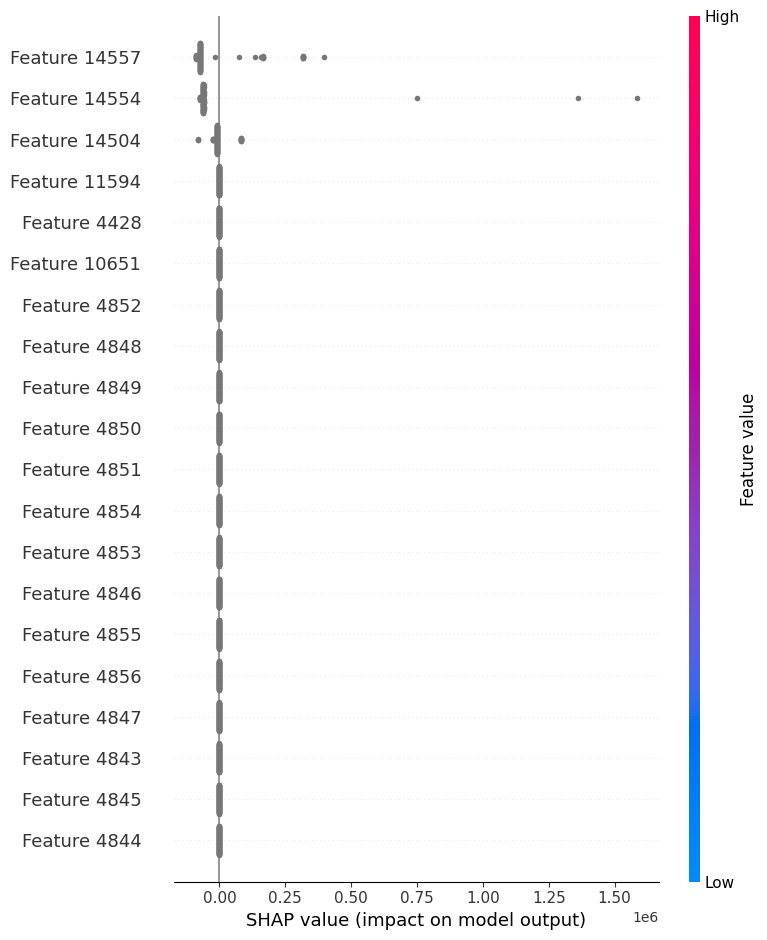

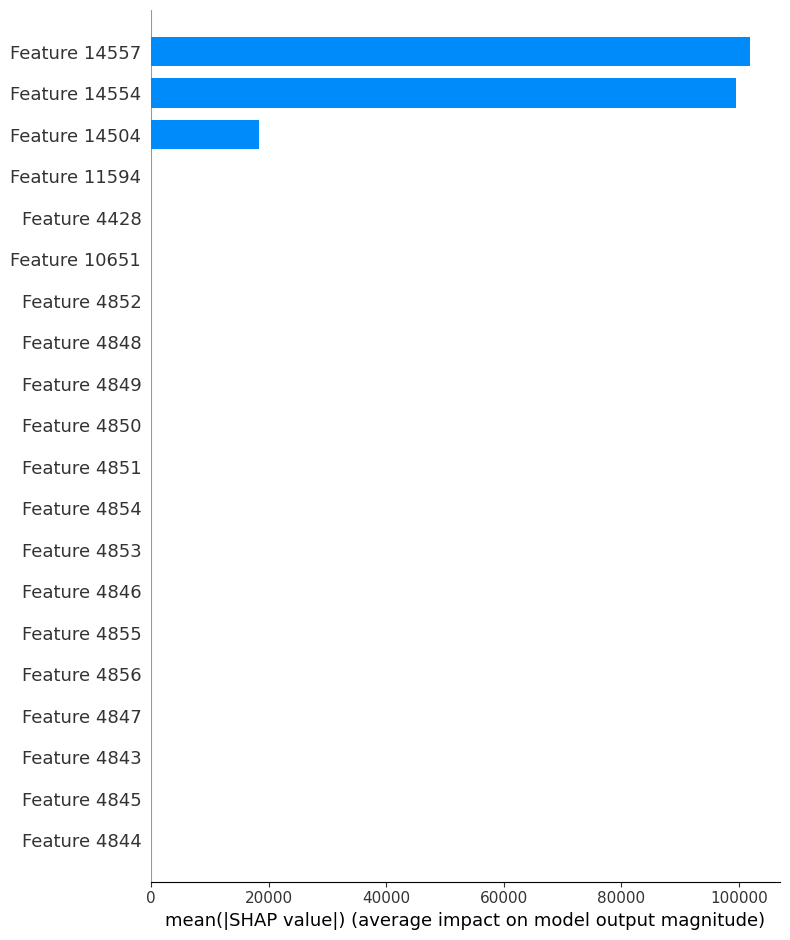

In [14]:
# Resumen de importancia de características
shap.summary_plot(shap_values, X_test_transformed)

# Mostrar el efecto de cada característica en la progresión de la diabetes
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")

plt.show()